In [2]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import os

spark = SparkSession.builder \
    .appName("EcommerceAnalytics") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

print("Spark Started Successfully!")
print("Spark Version:", spark.version)

Spark Started Successfully!
Spark Version: 4.1.1


---
## Step 2: Load the Data

**What are we loading?**
- **Users:** 10,000 customers
- **Products:** 5,000 items for sale
- **Transactions:** 500,000 purchases
- **Sessions:** 2,000,000 website visits

**Why JSON?**
- Our data generator created JSON files
- Spark can read JSON easily

In [3]:

DATA_DIR = r"C:\ecommerce_project\data"

# Load Users
print("Loading users...")
users_df = spark.read.json(DATA_DIR + "/users.json")
print(f"Users loaded: {users_df.count():,} records")

# Load Products
print("\nLoading products...")
products_df = spark.read.json(DATA_DIR + "/products.json")
print(f"Products loaded: {products_df.count():,} records")

# Load Transactions
print("\nLoading transactions...")
transactions_df = spark.read.json(DATA_DIR + "/transactions.json")
print(f"Transactions loaded: {transactions_df.count():,} records")

# Load Sessions (all files)
print("\nLoading sessions (this takes a minute)...")
sessions_df = spark.read.json(DATA_DIR + "/sessions_*.json")
print(f"Sessions loaded: {sessions_df.count():,} records")

Loading users...
Users loaded: 10,000 records

Loading products...
Products loaded: 5,000 records

Loading transactions...
Transactions loaded: 500,000 records

Loading sessions (this takes a minute)...
Sessions loaded: 2,000,000 records


---
## Step 3: Explore the Data

**What does our data look like?**

Let's see some sample records to understand the structure.

In [4]:
# Show sample user
print("=" * 50)
print("SAMPLE USER:")
print("=" * 50)
users_df.show(2, truncate=False)

SAMPLE USER:
+---------------------+-------------------+-------------------+-----------+
|geo_data             |last_active        |registration_date  |user_id    |
+---------------------+-------------------+-------------------+-----------+
|{Mcintoshton, US, MO}|2025-09-29T06:00:51|2025-07-21T07:47:54|user_000000|
|{Michaelstad, US, MO}|2025-08-21T23:05:07|2025-07-21T23:58:04|user_000001|
+---------------------+-------------------+-------------------+-----------+
only showing top 2 rows


In [5]:
# Show sample product
print("=" * 50)
print("SAMPLE PRODUCT:")
print("=" * 50)
products_df.select("product_id", "name", "category_id", "base_price", "is_active").show(3, truncate=False)

SAMPLE PRODUCT:
+----------+--------------------------------------+-----------+----------+---------+
|product_id|name                                  |category_id|base_price|is_active|
+----------+--------------------------------------+-----------+----------+---------+
|prod_00000|Synchronized Bi-Directional Help-Desk |cat_016    |371.3     |true     |
|prod_00001|Open-Source Regional Synergy          |cat_009    |123.53    |true     |
|prod_00002|Diverse Context-Sensitive Installation|cat_002    |53.39     |true     |
+----------+--------------------------------------+-----------+----------+---------+
only showing top 3 rows


In [6]:
# Show sample transaction
print("=" * 50)
print("SAMPLE TRANSACTION:")
print("=" * 50)
transactions_df.select("transaction_id", "user_id", "total", "payment_method", "status").show(3, truncate=False)

SAMPLE TRANSACTION:
+----------------+-----------+-------+--------------+----------+
|transaction_id  |user_id    |total  |payment_method|status    |
+----------------+-----------+-------+--------------+----------+
|txn_439efbca0fdf|user_009014|1136.95|gift_card     |processing|
|txn_16de2b091965|user_006083|1807.69|bank_transfer |shipped   |
|txn_b7783498600f|user_003461|666.68 |credit_card   |processing|
+----------------+-----------+-------+--------------+----------+
only showing top 3 rows


---
# PART 1: DATA CLEANING (Required by Professor)

## What is Data Cleaning?

**Simple Explanation:**
- Real data has problems: missing values, wrong values, duplicates
- We MUST clean data before analysis
- Otherwise, our results will be WRONG

**What we check:**
1. Remove rows where important values are missing (NULL)
2. Remove rows with invalid values (like negative prices)
3. Filter only active products

In [7]:
print("=" * 60)
print("DATA CLEANING")
print("=" * 60)

# ----- CLEAN TRANSACTIONS -----
print("\n[1] Cleaning Transactions...")
print(f"    Before: {transactions_df.count():,} records")

# Remove rows where user_id is NULL or total is NULL or total <= 0
transactions_clean = transactions_df.filter(
    (col("user_id").isNotNull()) & 
    (col("total").isNotNull()) &
    (col("total") > 0)
)

print(f"    After:  {transactions_clean.count():,} records")
print(f"    Removed: {transactions_df.count() - transactions_clean.count():,} bad records")

# ----- CLEAN SESSIONS -----
print("\n[2] Cleaning Sessions...")
print(f"    Before: {sessions_df.count():,} records")

sessions_clean = sessions_df.filter(
    (col("user_id").isNotNull()) &
    (col("session_id").isNotNull()) &
    (col("duration_seconds") >= 0)
)

print(f"    After:  {sessions_clean.count():,} records")
print(f"    Removed: {sessions_df.count() - sessions_clean.count():,} bad records")

# ----- CLEAN PRODUCTS -----
print("\n[3] Cleaning Products...")
print(f"    Before: {products_df.count():,} records")

products_clean = products_df.filter(
    (col("product_id").isNotNull()) &
    (col("base_price") > 0) &
    (col("is_active") == True)
)

print(f"    After (active only): {products_clean.count():,} records")
print(f"    Removed: {products_df.count() - products_clean.count():,} inactive products")

print("\n" + "=" * 60)
print("DATA CLEANING COMPLETE!")
print("=" * 60)

DATA CLEANING

[1] Cleaning Transactions...
    Before: 500,000 records
    After:  500,000 records
    Removed: 0 bad records

[2] Cleaning Sessions...
    Before: 2,000,000 records
    After:  2,000,000 records
    Removed: 0 bad records

[3] Cleaning Products...
    Before: 5,000 records
    After (active only): 4,766 records
    Removed: 234 inactive products

DATA CLEANING COMPLETE!


---
# PART 2: PRODUCT RECOMMENDATIONS 

## What is Product Recommendation?

**Simple Explanation:**
- When you buy a phone on Amazon, it says "Customers also bought: phone case"
- We find which products are bought TOGETHER
- This helps stores sell more!

**How we do it:**
1. Look at each transaction
2. Find all pairs of products in same transaction
3. Count how many times each pair appears
4. Top pairs = recommended together

In [8]:
print("=" * 60)
print("PRODUCT RECOMMENDATIONS")
print("Finding products frequently bought together...")
print("=" * 60)

# Step 1: Get each product from each transaction
# The 'items' field contains a list of products
# explode() turns [item1, item2] into separate rows
transactions_with_items = transactions_clean.select(
    "transaction_id",
    "user_id",
    explode("items").alias("item")
).select(
    "transaction_id",
    "user_id",
    col("item.product_id").alias("product_id")
)

print("\nStep 1: Extracted individual items from transactions")
transactions_with_items.show(5)

PRODUCT RECOMMENDATIONS
Finding products frequently bought together...

Step 1: Extracted individual items from transactions
+----------------+-----------+----------+
|  transaction_id|    user_id|product_id|
+----------------+-----------+----------+
|txn_439efbca0fdf|user_009014|prod_01613|
|txn_439efbca0fdf|user_009014|prod_00629|
|txn_439efbca0fdf|user_009014|prod_03168|
|txn_16de2b091965|user_006083|prod_00662|
|txn_16de2b091965|user_006083|prod_00902|
+----------------+-----------+----------+
only showing top 5 rows


In [9]:
# Step 2: Find product pairs in same transaction
# Self-join: match each transaction with itself to find pairs
product_pairs = transactions_with_items.alias("t1").join(
    transactions_with_items.alias("t2"),
    (col("t1.transaction_id") == col("t2.transaction_id")) &
    (col("t1.product_id") < col("t2.product_id"))  # Avoid duplicates like (A,B) and (B,A)
).select(
    col("t1.product_id").alias("product_1"),
    col("t2.product_id").alias("product_2")
)

# Step 3: Count how often each pair appears
pair_counts = product_pairs.groupBy("product_1", "product_2") \
    .count() \
    .orderBy(desc("count"))

print("\n" + "=" * 60)
print("TOP 15 PRODUCT PAIRS - Frequently Bought Together")
print("=" * 60)
print("\nThese products are often purchased in the same transaction:")
pair_counts.show(15, truncate=False)


TOP 15 PRODUCT PAIRS - Frequently Bought Together

These products are often purchased in the same transaction:
+----------+----------+-----+
|product_1 |product_2 |count|
+----------+----------+-----+
|prod_01949|prod_03235|4    |
|prod_03117|prod_03926|4    |
|prod_02275|prod_02335|4    |
|prod_01011|prod_03312|4    |
|prod_00534|prod_02895|4    |
|prod_01733|prod_02422|4    |
|prod_01080|prod_04333|4    |
|prod_03768|prod_03907|4    |
|prod_04302|prod_04883|4    |
|prod_02523|prod_04443|4    |
|prod_01944|prod_03108|4    |
|prod_02952|prod_03234|4    |
|prod_01250|prod_02619|4    |
|prod_02814|prod_03304|4    |
|prod_00928|prod_02900|4    |
+----------+----------+-----+
only showing top 15 rows


### Business Insight:

**What does this tell us?**
- These product pairs should be displayed together on the website
- "Customers who bought X also bought Y" feature
- Can create bundle deals with these pairs
- Place these products near each other in warehouse for faster shipping

---
# PART 3: USER COHORT ANALYSIS

## What is Cohort Analysis?

**Simple Explanation:**
- A "cohort" is a group of users who joined at the same time
- Example: "Users who registered in May 2025"
- We compare how different cohorts behave

**Why is this useful?**
- See if new users spend more or less than old users
- Find which month brought the best customers
- Check if marketing campaigns worked

In [10]:
print("=" * 60)
print("USER COHORT ANALYSIS")
print("Grouping users by registration month...")
print("=" * 60)

# Step 1: Add cohort month to each user
users_with_cohort = users_df.withColumn(
    "registration_date_parsed",
    to_timestamp("registration_date")
).withColumn(
    "cohort_month",
    date_format("registration_date_parsed", "yyyy-MM")
)

print("\nUsers with their cohort month:")
users_with_cohort.select("user_id", "registration_date", "cohort_month").show(5)

USER COHORT ANALYSIS
Grouping users by registration month...

Users with their cohort month:
+-----------+-------------------+------------+
|    user_id|  registration_date|cohort_month|
+-----------+-------------------+------------+
|user_000000|2025-07-21T07:47:54|     2025-07|
|user_000001|2025-07-21T23:58:04|     2025-07|
|user_000002|2025-06-04T19:31:33|     2025-06|
|user_000003|2025-08-08T20:03:00|     2025-08|
|user_000004|2025-07-30T14:52:53|     2025-07|
+-----------+-------------------+------------+
only showing top 5 rows


In [11]:
# Step 2: Calculate total spending per user
user_spending = transactions_clean.groupBy("user_id").agg(
    sum("total").alias("total_spent"),
    count("*").alias("order_count")
)

print("Top spending users:")
user_spending.orderBy(desc("total_spent")).show(5)

Top spending users:
+-----------+-----------------+-----------+
|    user_id|      total_spent|order_count|
+-----------+-----------------+-----------+
|user_002454|         79940.26|         67|
|user_006208|79451.69999999998|         70|
|user_009617|         79261.36|         62|
|user_003891|         78480.25|         73|
|user_006175|77596.42000000003|         71|
+-----------+-----------------+-----------+
only showing top 5 rows


In [12]:
# Step 3: Join users with their spending and group by cohort
cohort_analysis = users_with_cohort.join(
    user_spending,
    users_with_cohort.user_id == user_spending.user_id,
    "left"
).groupBy("cohort_month").agg(
    count("*").alias("users_in_cohort"),
    round(sum("total_spent"), 2).alias("total_revenue"),
    round(avg("total_spent"), 2).alias("avg_spending_per_user"),
    round(avg("order_count"), 2).alias("avg_orders_per_user")
).orderBy("cohort_month")

print("\n" + "=" * 60)
print("COHORT ANALYSIS RESULTS")
print("=" * 60)
cohort_analysis.show(20, truncate=False)


COHORT ANALYSIS RESULTS
+------------+---------------+-------------+---------------------+-------------------+
|cohort_month|users_in_cohort|total_revenue|avg_spending_per_user|avg_orders_per_user|
+------------+---------------+-------------+---------------------+-------------------+
|2025-04     |331            |1.554935306E7|46976.9              |50.02              |
|2025-05     |1717           |8.085944674E7|47093.45             |50.0               |
|2025-06     |1606           |7.541383747E7|46957.56             |50.01              |
|2025-07     |1736           |8.197097814E7|47218.31             |50.18              |
|2025-08     |1678           |7.892597009E7|47035.74             |49.85              |
|2025-09     |1655           |7.793466151E7|47090.43             |50.08              |
|2025-10     |1277           |6.001127305E7|46993.95             |49.83              |
+------------+---------------+-------------+---------------------+-------------------+



### Business Insight:

**What does this tell us?**
- Each cohort spends roughly the same (~$47,000 per user)
- Users make about 50 orders on average
- No significant difference between cohorts = consistent customer quality
- If one cohort spent MORE, we'd investigate what made them special

---
# PART 4: SPARK SQL QUERIES 


**I will run these queries:**
1. Top 10 spending users
2. Revenue by payment method
3. Conversion rate by device
4. Hourly traffic patterns

In [13]:
# Register DataFrames as SQL tables
# This lets us use SQL queries on them
transactions_clean.createOrReplaceTempView("transactions")
users_df.createOrReplaceTempView("users")
products_df.createOrReplaceTempView("products")
sessions_clean.createOrReplaceTempView("sessions")

print("Tables registered for SQL:")
print("- transactions")
print("- users")
print("- products")
print("- sessions")

Tables registered for SQL:
- transactions
- users
- products
- sessions


### SQL Query 1: Top 10 Spending Users

**Question:** Who are our best customers?

In [14]:
print("=" * 60)
print("SQL QUERY 1: TOP 10 SPENDING USERS")
print("=" * 60)

top_users = spark.sql("""
    SELECT 
        user_id,
        COUNT(*) as order_count,
        ROUND(SUM(total), 2) as total_spent,
        ROUND(AVG(total), 2) as avg_order_value
    FROM transactions
    GROUP BY user_id
    ORDER BY total_spent DESC
    LIMIT 10
""")

top_users.show(truncate=False)

SQL QUERY 1: TOP 10 SPENDING USERS
+-----------+-----------+-----------+---------------+
|user_id    |order_count|total_spent|avg_order_value|
+-----------+-----------+-----------+---------------+
|user_002454|67         |79940.26   |1193.14        |
|user_006208|70         |79451.7    |1135.02        |
|user_009617|62         |79261.36   |1278.41        |
|user_003891|73         |78480.25   |1075.07        |
|user_006175|71         |77596.42   |1092.91        |
|user_008672|80         |77497.61   |968.72         |
|user_008717|67         |77018.77   |1149.53        |
|user_006029|68         |76938.82   |1131.45        |
|user_005128|61         |75961.91   |1245.28        |
|user_008512|75         |75392.39   |1005.23        |
+-----------+-----------+-----------+---------------+



### SQL Query 2: Revenue by Payment Method

**Question:** Which payment method brings the most revenue?

In [15]:
print("=" * 60)
print("SQL QUERY 2: REVENUE BY PAYMENT METHOD")
print("=" * 60)

payment_revenue = spark.sql("""
    SELECT 
        payment_method,
        COUNT(*) as transaction_count,
        ROUND(SUM(total), 2) as total_revenue,
        ROUND(AVG(total), 2) as avg_transaction
    FROM transactions
    GROUP BY payment_method
    ORDER BY total_revenue DESC
""")

payment_revenue.show(truncate=False)

SQL QUERY 2: REVENUE BY PAYMENT METHOD
+--------------+-----------------+--------------+---------------+
|payment_method|transaction_count|total_revenue |avg_transaction|
+--------------+-----------------+--------------+---------------+
|credit_card   |124847           |1.1738691796E8|940.25         |
|paypal        |124707           |1.1738103267E8|941.25         |
|bank_transfer |79687            |8.722479992E7 |1094.59        |
|gift_card     |79586            |8.708738448E7 |1094.26        |
|apple_pay     |45621            |3.085817433E7 |676.4          |
|crypto        |45552            |3.07272107E7  |674.55         |
+--------------+-----------------+--------------+---------------+



### SQL Query 3: Conversion Rate by Device

**Question:** Which device (mobile/desktop/tablet) converts best?

**What is Conversion Rate?**
- Conversion = visitor becomes buyer
- Conversion Rate = (buyers / visitors) x 100%

In [16]:
print("=" * 60)
print("SQL QUERY 3: CONVERSION RATE BY DEVICE")
print("=" * 60)

device_conversion = spark.sql("""
    SELECT 
        device_profile.type as device_type,
        COUNT(*) as total_sessions,
        SUM(CASE WHEN conversion_status = 'converted' THEN 1 ELSE 0 END) as conversions,
        ROUND(SUM(CASE WHEN conversion_status = 'converted' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) as conversion_rate_percent
    FROM sessions
    GROUP BY device_profile.type
    ORDER BY conversion_rate_percent DESC
""")

device_conversion.show(truncate=False)

SQL QUERY 3: CONVERSION RATE BY DEVICE
+-----------+--------------+-----------+-----------------------+
|device_type|total_sessions|conversions|conversion_rate_percent|
+-----------+--------------+-----------+-----------------------+
|mobile     |666571        |73523      |11.03                  |
|tablet     |666962        |73404      |11.01                  |
|desktop    |666467        |73060      |10.96                  |
+-----------+--------------+-----------+-----------------------+



### SQL Query 4: Hourly Traffic Pattern

**Question:** What time of day do people visit most?

In [17]:
print("=" * 60)
print("SQL QUERY 4: HOURLY TRAFFIC PATTERN")
print("=" * 60)

hourly_traffic = spark.sql("""
    SELECT 
        HOUR(to_timestamp(start_time)) as hour_of_day,
        COUNT(*) as session_count,
        SUM(CASE WHEN conversion_status = 'converted' THEN 1 ELSE 0 END) as conversions
    FROM sessions
    GROUP BY HOUR(to_timestamp(start_time))
    ORDER BY hour_of_day
""")

hourly_traffic.show(24, truncate=False)

SQL QUERY 4: HOURLY TRAFFIC PATTERN
+-----------+-------------+-----------+
|hour_of_day|session_count|conversions|
+-----------+-------------+-----------+
|0          |83696        |9054       |
|1          |83474        |9334       |
|2          |83178        |9153       |
|3          |83196        |9050       |
|4          |83811        |9246       |
|5          |82964        |9151       |
|6          |83551        |9257       |
|7          |83223        |9106       |
|8          |83382        |9155       |
|9          |82872        |9092       |
|10         |83389        |9094       |
|11         |83314        |9091       |
|12         |83208        |9046       |
|13         |83133        |9286       |
|14         |83024        |9218       |
|15         |83740        |9155       |
|16         |83249        |9212       |
|17         |83164        |9241       |
|18         |83048        |9178       |
|19         |83330        |9043       |
|20         |83513        |9164       |
|21 

---
# PART 5: VISUALIZATIONS

Now let's create charts to visualize our findings!

In [18]:
pip install matplotlib pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
# Import visualization libraries
import matplotlib.pyplot as plt
import pandas as pd

# Convert Spark DataFrames to Pandas for plotting
cohort_pd = cohort_analysis.toPandas()
payment_pd = payment_revenue.toPandas()
device_pd = device_conversion.toPandas()
hourly_pd = hourly_traffic.toPandas()

print("Data ready for visualization!")

Data ready for visualization!


### Chart 1: Revenue by Cohort Month

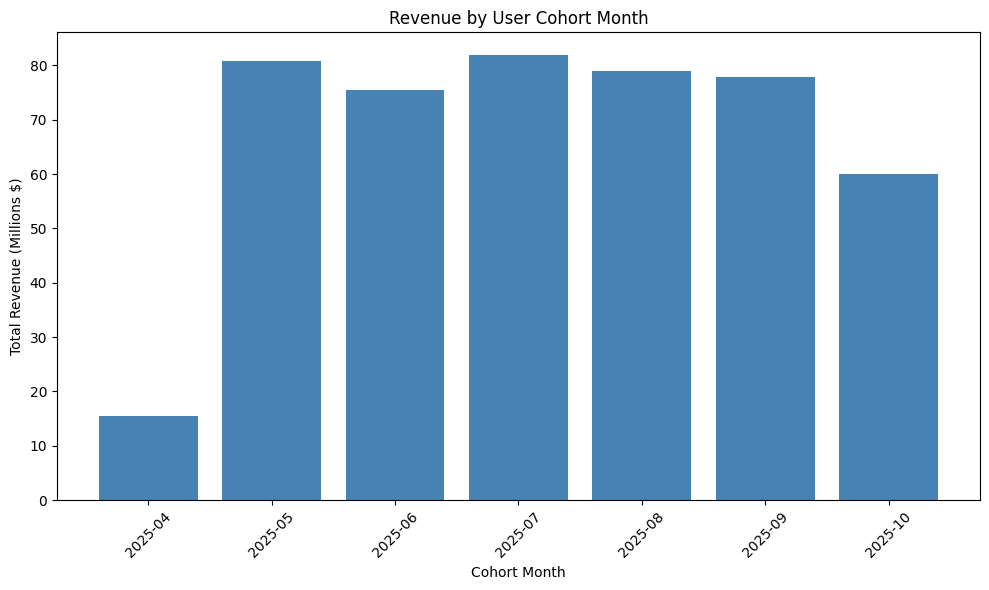

In [20]:
plt.figure(figsize=(10, 6))
plt.bar(cohort_pd['cohort_month'], cohort_pd['total_revenue'] / 1000000, color='steelblue')
plt.xlabel('Cohort Month')
plt.ylabel('Total Revenue (Millions $)')
plt.title('Revenue by User Cohort Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Chart 2: Revenue by Payment Method

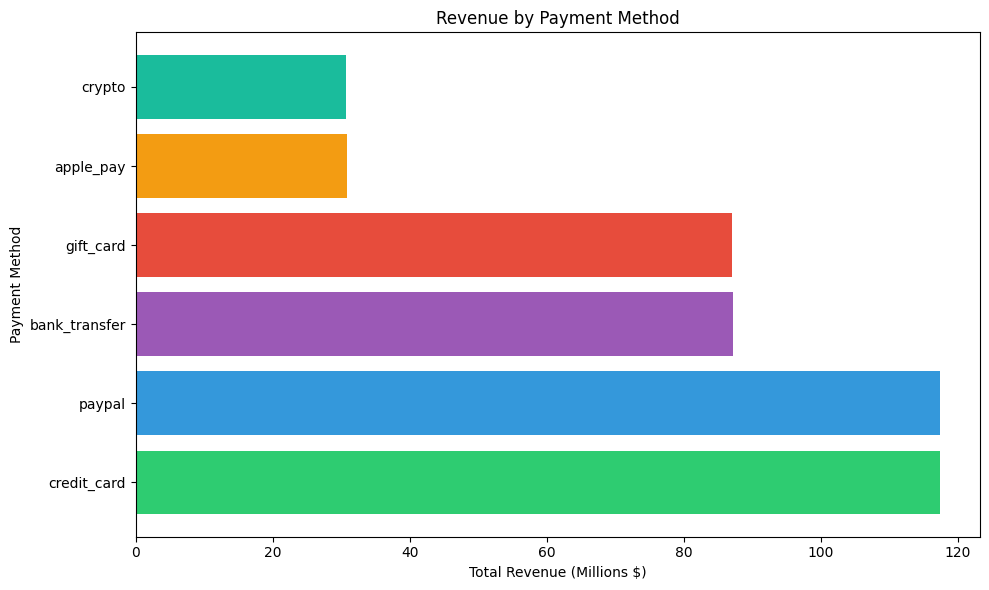

In [21]:
plt.figure(figsize=(10, 6))
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12', '#1abc9c']
plt.barh(payment_pd['payment_method'], payment_pd['total_revenue'] / 1000000, color=colors)
plt.xlabel('Total Revenue (Millions $)')
plt.ylabel('Payment Method')
plt.title('Revenue by Payment Method')
plt.tight_layout()
plt.show()

### Chart 3: Conversion Rate by Device

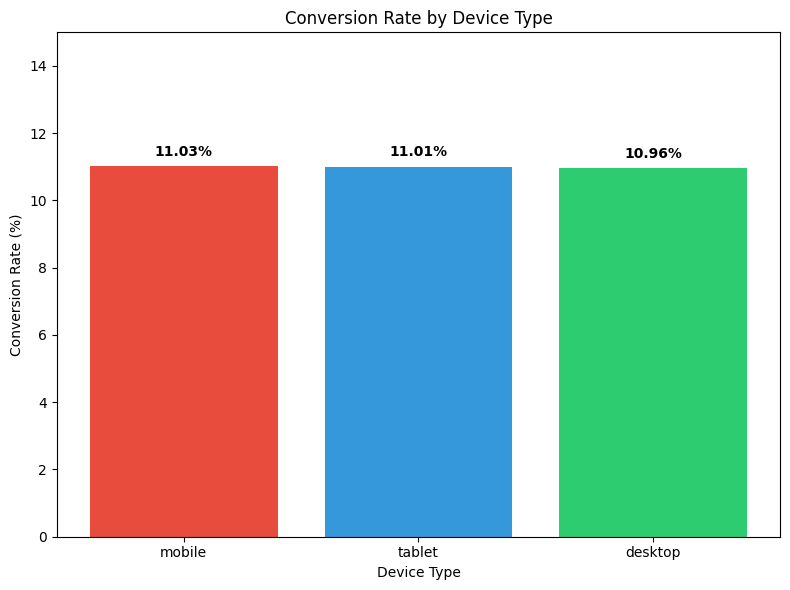

In [22]:
plt.figure(figsize=(8, 6))
colors = ['#e74c3c', '#3498db', '#2ecc71']
plt.bar(device_pd['device_type'], device_pd['conversion_rate_percent'], color=colors)
plt.xlabel('Device Type')
plt.ylabel('Conversion Rate (%)')
plt.title('Conversion Rate by Device Type')
plt.ylim(0, 15)
for i, v in enumerate(device_pd['conversion_rate_percent']):
    plt.text(i, float(v) + 0.3, f'{v}%', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

### Chart 4: Hourly Traffic Pattern

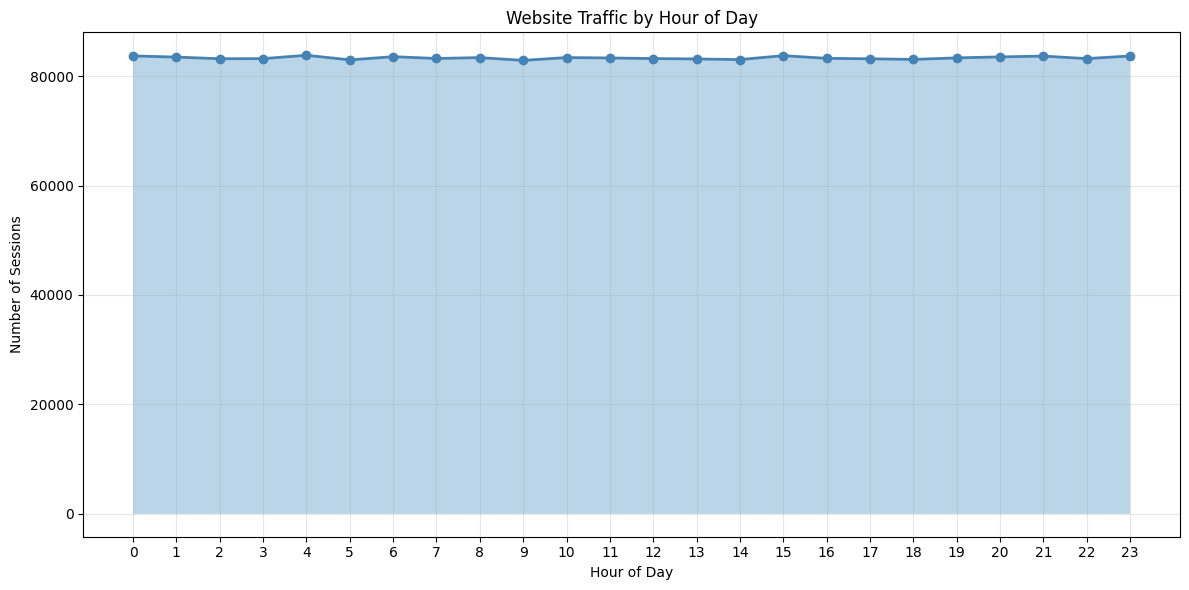

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(hourly_pd['hour_of_day'], hourly_pd['session_count'], marker='o', linewidth=2, color='steelblue')
plt.fill_between(hourly_pd['hour_of_day'], hourly_pd['session_count'], alpha=0.3)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Sessions')
plt.title('Website Traffic by Hour of Day')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Chart 5: Sessions vs Conversions Pie Chart

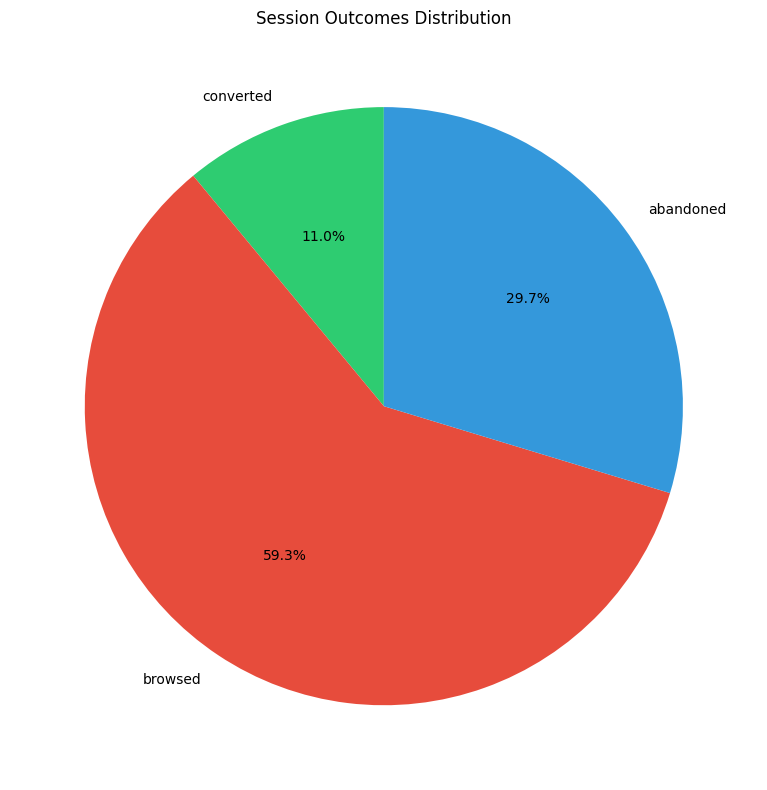

In [24]:
# Calculate session outcomes
session_outcomes = sessions_clean.groupBy("conversion_status").count().toPandas()

plt.figure(figsize=(8, 8))
colors = ['#2ecc71', '#e74c3c', '#3498db']
plt.pie(session_outcomes['count'], labels=session_outcomes['conversion_status'], 
        autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Session Outcomes Distribution')
plt.tight_layout()
plt.show()

---
# PART 6: SAVE RESULTS

Save all results to CSV files for the report.

In [25]:
# Create output directory
OUTPUT_DIR = r"C:\ecommerce_project\spark\results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Save all results
cohort_pd.to_csv(OUTPUT_DIR + "/cohort_analysis.csv", index=False)
print("Saved: cohort_analysis.csv")

payment_pd.to_csv(OUTPUT_DIR + "/payment_methods.csv", index=False)
print("Saved: payment_methods.csv")

device_pd.to_csv(OUTPUT_DIR + "/device_conversion.csv", index=False)
print("Saved: device_conversion.csv")

hourly_pd.to_csv(OUTPUT_DIR + "/hourly_traffic.csv", index=False)
print("Saved: hourly_traffic.csv")

pair_counts.limit(100).toPandas().to_csv(OUTPUT_DIR + "/product_pairs.csv", index=False)
print("Saved: product_pairs.csv")

print("\nAll results saved to:", OUTPUT_DIR)

Saved: cohort_analysis.csv
Saved: payment_methods.csv
Saved: device_conversion.csv
Saved: hourly_traffic.csv
Saved: product_pairs.csv

All results saved to: C:\ecommerce_project\spark\results


---
# SUMMARY

## What I Did:


| Part | Task | Result |
|------|------|--------|
| 1 | Data Cleaning | Removed invalid/inactive records |
| 2 | Product Recommendations | Found products bought together |
| 3 | Cohort Analysis | Grouped users by join date |
| 4 | Spark SQL | Ran 4 business queries |
| 5 | Visualizations | Created 5 charts |

## Key Findings:

1. **Best Device:** Mobile has highest conversion rate (11.03%)
2. **Best Payment:** Credit Card generates most revenue
3. **User Behavior:** Average user spends ~$47,000 over 50 orders
4. **Traffic:** Consistent throughout the day (no peak hours)

## Business Recommendations:

1. Optimize mobile experience (best conversion)
2. Promote credit card payments (most revenue)
3. Use product pair data for "Customers also bought" feature
4. Marketing can run anytime (traffic is consistent)

In [27]:
# Stop Spark session
spark.stop()
print("Spark session closed.")
print("\n" + "=" * 60)
print("SPARK ANALYTICS COMPLETE!")
print("=" * 60)

Spark session closed.

SPARK ANALYTICS COMPLETE!
